In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
# Read some dank data into the dank DataFrames
df1 = pd.read_csv('ADemoCiv1.txt')
df6 = pd.read_csv('MDemoCiv6.txt')
df7 = pd.read_csv('MDemoCiv7.txt')

[  313.24839274  9710.58162374] [ 0.00022434  0.05426882]


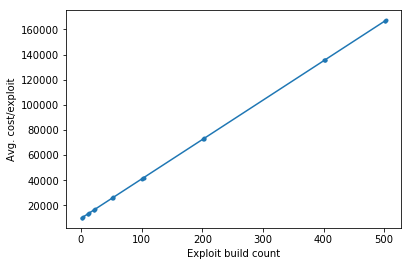

In [301]:
# print(df6.head())
coef, cov = np.polyfit(df6['ExpCount'], df6['Cost']/df6['ExpCount'], deg=1, cov=True)
print(coef, np.sqrt(np.diag(cov)))
plt.plot(df6['ExpCount'], df6['Cost']/df6['ExpCount'], '.-')
plt.xlabel('Exploit build count')
plt.ylabel('Avg. cost/exploit')

# Observations:

1. We see an effectively perfectly linear trend in the average cost per exploit vs number of exploits built. This means that the slope of this line is the rate of change in average exploit price. Given that one end is constant (the base exploit price, the price to make 1 exploit), the rate of change of exploit price is twice the rate of change of average exploit price.
2. The two coefficients, 313.25, and 9710.58 is the rate of change of average cost per exploit, and the cost of '0' exploits, i.e, the y-intercept of the data. Adding these two numbers gives us the base exploit price.

[  310.11591799  9613.4725892 ] [ 0.00017988  0.04351538]


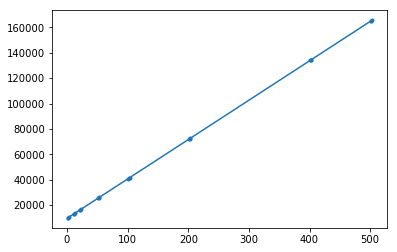

In [216]:
# print(df7.head())
coef, cov = np.polyfit(df7['ExpCount'], df7['Cost']/df7['ExpCount'], deg=1, cov=True)
print(coef, np.sqrt(np.diag(cov)))
plt.plot(df7['ExpCount'], df7['Cost']/df7['ExpCount'], '.-')
plt.xlabel('Exploit build count')
plt.ylabel('Avg. cost/exploit')

# Observations:

1. Same as before. We see that the two coefficients have changed. This leads us to think that the coefficients may be a function of civ level, since that is the only economic quantity that is different between the two sets.

Furthermore, we notice that the coefficients for civ7 are 99% of civ6, to within a very small (<=fp32 precision) error:

In [222]:
print('Slope ratio between civ7 and civ6:', 310.11591799/313.24839274)

Slope ratio between civ7 and civ6: 0.9900000292975167


[   329.39189995  10211.02123577] [ 0.00017022  0.03902458]


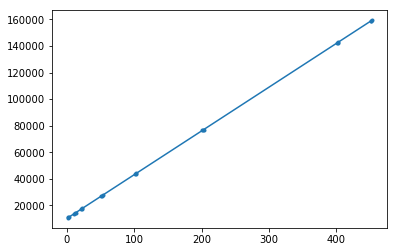

In [219]:
# print(df1.head())
coef, cov = np.polyfit(df1['ExpCount'], df1['Cost']/df1['ExpCount'], deg=1, cov=True)
print(coef, np.sqrt(np.diag(cov)))
plt.plot(df1['ExpCount'], df1['Cost']/df1['ExpCount'], '.-')
plt.xlabel('Exploit build count')
plt.ylabel('Avg. cost/exploit')

# Observations:

1. Finally, we have the 'naught' coefficients. Civ 1 is the base civ level, and the coefficients here should be able to predict the coefficients for all other civ levels with appropriate scaling laws. This is the hypothesis: Gov remaining constant, the rate of change of average exploit price, the slope, which we call $\alpha$ from hereon, decreases by 1% every civ level. The ingame tech tree hints at this being a possibility.

In [229]:
def rel_err(a, b):
    return np.abs(a-b)/b

In [235]:
alpha_one, beta_one = 329.3919, 10211.02
alpha_six, beta_six = 313.2484, 9710.58
alpha_seven, beta_seven = 310.1159, 9613.47

print(r"Testing alpha_one and alpha_seven:", alpha_seven/alpha_one, 0.99**(7-1), 
      rel_err(alpha_seven/alpha_one, 0.99**(7-1)))
print(r"Testing alpha_one and alpha_six:", alpha_six/alpha_one, 0.99**(6-1), 
      rel_err(alpha_six/alpha_one, 0.99**(6-1)))

Testing alpha_one and alpha_seven: 0.9414800424661323 0.941480149401 1.13581648861e-07
Testing alpha_one and alpha_six: 0.9509899909499899 0.9509900498999999 6.19880407695e-08


We have excellent agreement in both cases.

# Predictions:
We attempt to start predicting using the following formula:
$$P = sum(0.99^{L-1}*G*[\beta_1+\alpha_1+2*\alpha_1*range(n)]))$$
Where $L$ is the target civ level and $G$ is the gov factor. The gov factor is experimentally determined to be 1 for Demo, 0.9 for Auth, and 0.8 for Demo. The Hyps factor has not been determined yet but is expected to be either 1.05 or 1.1

The $\beta_1+\alpha_1$ part of the above equation is the base price of 1 exploit.

## Predicting price of 275 exploits on a DemoCiv1:

In [251]:
alpha, beta = alpha_one, beta_one

In [256]:
n = np.arange(275)
predicted_cost = np.round(np.sum(beta+alpha + 2*alpha*n))
print('Predicted:', predicted_cost)
print('Actual:', 27718299)
print('Error:', rel_err(predicted_cost, 27718299))

Predicted: 27718293.0
Actual: 27718299
Error: 2.16463499438e-07


## Predicting price of 567 exploits on a DemoCiv7:

In [260]:
civ_adjust = 6 # 7-1
alpha_seven, beta_seven = alpha*0.99**civ_adjust, beta*0.99**civ_adjust
n = np.arange(567)
predicted_cost = np.round(np.sum(beta_seven+alpha_seven + 2*alpha_seven*n))
print('Predicted:', predicted_cost)
print('Actual:', 105149661)
print('Error:', rel_err(predicted_cost, 105149661))

Predicted: 105149701.0
Actual: 105149661
Error: 3.80410166039e-07


In [271]:
n1, n2 = np.arange(215), np.arange(375)

predicted_cost_1 = np.round(np.sum(beta_seven+alpha_seven + 2*alpha_seven*n1))
predicted_cost_2 = np.round(np.sum(beta_seven+alpha_seven + 2*alpha_seven*n2))

print('Predicted 215:', predicted_cost_1)
print('Predicted 375:', predicted_cost_2)

print('Actual 215:', 16402015)
print('Actual 375:', 47215102)
print('Error 215:', rel_err(predicted_cost_1, 16402015))
print('Error 375:', rel_err(predicted_cost_2, 47215102))

Predicted 215: 16402006.0
Predicted 375: 47215106.0
Actual 215: 16402015
Actual 375: 47215102
Error 215: 5.48713069705e-07
Error 375: 8.47186563316e-08


In [281]:
# Investment from 215 to 375 exploits:
predict_215_375_demo7 = predicted_cost_2-predicted_cost_1
actual_215_375_demo7 = 47215102-16402015
predict_215_375_demo7, actual_215_375_demo7, rel_err(predict_215_375_demo7, actual_215_375_demo7)

(30813100.0, 30813087, 4.2189865624304375e-07)

# Planets with exploits on them:
We now attempt to find a mathematical model for planets with already present exploits, since this is a more realistic case:

Alpha and beta: [  2.43155561e+02   1.07742172e+06]
Error in alpha and beta: [  8.90393946e-05   4.74372132e-02]
Adjusted beta for dict and civ 9:
Relative error inredicted and observed alpha: 5.82868034426e-07


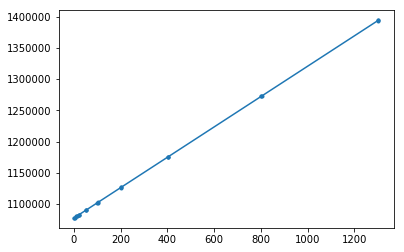

In [287]:
df9_2400 = pd.read_csv('ADictCiv9_2400Offset.txt') # Notice change in government.
count9_2400, cost9_2400 = np.array(df9_2400).T

plt.plot(count9_2400, cost9_2400/count9_2400, '.-')
plt.xlabel('Exploit build count')
plt.ylabel('Avg. cost/exploit')

coef, cov = np.polyfit(count9_2400, cost9_2400/(count9_2400), deg=1, cov=True)

predicted_alpha = 0.8*alpha_one*0.99**8

print('Alpha and beta:', coef)
print('Error in alpha and beta:', np.sqrt(np.diag(cov)))
print('Adjusted beta for dict and civ 9:', )
print('Relative error inredicted and observed alpha:', rel_err(predicted_alpha, coef[0]))

Relative error in alpha: 1.52524573631e-07


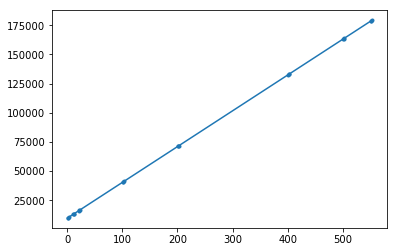

In [291]:
df_demo8 = pd.read_csv('MDemoCiv8.txt')
count8, cost8 = np.array(df_demo8).T

predicted_alpha = alpha_one*0.99**7

plt.plot(count8, cost8/count8, '.-')
plt.xlabel('Exploit build count')
plt.ylabel('Avg. cost/exploit')

coef, cov = np.polyfit(count8, cost8/count8, deg=1, cov=True)
print('Relative error in alpha:', rel_err(predicted_alpha, coef[0]))

# Civ levels with no exploit tech:

Although suboptimal, some players may not have exploit tech to give them the 30% exploit cost discount, in which case, they will be charged 1/0.7 times the exploit expenses shown here. This means that all the coefficients must also scale accordingly, if the hypothesis is true.

Alpha and beta: [  3.23767077e+02   3.24770481e+06]
Predicted alpha: 323.76714919562045
Fit alpha: 323.767076874
Relative error: 2.23375789663e-07


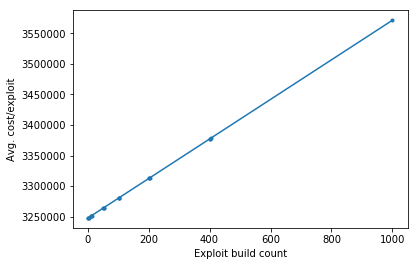

In [302]:
df16_5000 = pd.read_csv('XDictCiv16_5000Offset.txt')
count16_500, cost16_5000 = np.array(df16_5000).T

plt.plot(count16_500, cost16_5000/count16_500, '.-')
plt.xlabel('Exploit build count')
plt.ylabel('Avg. cost/exploit')

coef, cov = np.polyfit(count16_500, cost16_5000/count16_500, deg=1, cov=True)

predicted_alpha = 0.8*alpha_one*0.99**15/0.7 # /0.7 because no exploit tech.
print('Alpha and beta:', coef)
print('Predicted alpha:', predicted_alpha)
print('Fit alpha:', coef[0])
print('Relative error:', rel_err(predicted_alpha, coef[0]))